# **Sales Performance & Customer Retention Analysis (Q4 2025)**
---
**Objective:** 
1. Menganalisis tren penjualan bulanan dari Oktober hingga Desember 2025.
2. Mengevaluasi kontribusi pendapatan dari tiap cabang.
3. Mengidentifikasi tingkat churn pelanggan berdasarkan tipe membership untuk strategi retensi ke depan.

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## LOAD DATA

In [82]:
df = pd.read_csv('penjualan_raw.csv')
print(df.head())

  Transaction_ID        Date Customer_ID Customer_Name    Product_Name  \
0        TRX1000  2025-11-21        C133          Andi  CHEDDAR CHEESE   
1        TRX1001  2026-01-01        C146          Budi          butter   
2        TRX1002  2025-10-15        C107          Andi    Greek Yogurt   
3        TRX1003  2025-12-11        C139          Siti    organic milk   
4        TRX1004  2025-11-30        C148          Dewi          butter   

     Branch  Quantity  Sold_Price Membership Status_Churn  
0       BDG         4     13200.0       Gold       Active  
1       JKT         2     28100.0     Silver        Churn  
2   Bandung         3     39600.0     Bronze        Churn  
3       BDG         1     37500.0     Silver       Active  
4  Surabaya         1     42600.0     gold          Churn  


In [83]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Transaction_ID  1030 non-null   object 
 1   Date            1030 non-null   object 
 2   Customer_ID     1030 non-null   object 
 3   Customer_Name   823 non-null    object 
 4   Product_Name    1030 non-null   object 
 5   Branch          1030 non-null   object 
 6   Quantity        1030 non-null   int64  
 7   Sold_Price      1030 non-null   float64
 8   Membership      1030 non-null   object 
 9   Status_Churn    930 non-null    object 
dtypes: float64(1), int64(1), object(8)
memory usage: 80.6+ KB


,Quantity,Sold_Price
count,1030.000000,1030.000000
mean,3.085437,29784.854369
std,10.203778,11463.214659
min,-5.000000,10100.000000
25%,1.000000,20025.000000
50%,2.000000,29800.000000
75%,3.000000,39600.000000
max,100.000000,50000.000000


## DATA CLEANING

In [89]:
# 1. Inisialisasi & Hitung Data Awal
total_awal = len(df)
df_clean = df.copy()

# 2. Standarisasi Teks Awal (Penting sebelum drop_duplicates)
# Kita bersihkan spasi dan kapitalisasi dulu supaya duplikat ' gold' dan 'Gold' terdeteksi
df_clean['Membership'] = df_clean['Membership'].str.strip().str.title()
df_clean['Status_Churn'] = df_clean['Status_Churn'].str.strip().str.capitalize()
df_clean['Product_Name'] = df_clean['Product_Name'].str.strip().str.title()
df_clean['Customer_Name'] = df_clean['Customer_Name'].str.strip().str.title().fillna('Unknown')

# 3. Hapus Duplikat Identik
rows_before_dup = len(df_clean)
df_clean = df_clean.drop_duplicates()
total_duplikat = rows_before_dup - len(df_clean)
print(f"✅ Duplikat dihapus: {total_duplikat} baris")

# 4. Filter Status yang Valid (Business Logic)
# Kita fokus ke 'Active' & 'Churn'. Data 'n/a' dibuang (bukan diisi 'Active' agar analisis Churn jujur)
rows_before_status = len(df_clean)
df_clean = df_clean[df_clean['Status_Churn'].isin(['Active', 'Churn'])]
total_invalid_status = rows_before_status - len(df_clean)

# 5. Menangani Outlier Numerik (Screening Outlier)
# Ini yang lo mau cantumin di laporan: Qty > 50 atau Qty <= 0
rows_before_outlier = len(df_clean)
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['Quantity'] <= 50)]
total_outlier_qty = rows_before_outlier - len(df_clean)
print(f"✅ Outlier Quantity dihapus: {total_outlier_qty} baris")

# 6. Konsistensi Nama Cabang & Tanggal
branch_mapping = {'JKT': 'Jakarta', 'BDG': 'Bandung'}
df_clean['Branch'] = df_clean['Branch'].replace(branch_mapping)
df_clean['Date'] = pd.to_datetime(df_clean['Date'])

# 7. Filter Tahun & Hitung Revenue
df_clean = df_clean[df_clean['Date'].dt.year == 2025]
df_clean['Total_Sales'] = df_clean['Quantity'] * df_clean['Sold_Price']

print("-" * 30)
print(f"📊 HASIL SCREENING DATA:")
print(f"   - Total Data Mentah   : {total_awal}")
print(f"   - Total Duplikat      : {total_duplikat}")
print(f"   - Status Tak Valid    : {total_invalid_status}")
print(f"   - Outlier Qty (>50)   : {total_outlier_qty}")
print(f"   - TOTAL DATA BERSIH   : {len(df_clean)}")
print("-" * 30)

df_clean.head()

✅ Duplikat dihapus: 7 baris
✅ Outlier Quantity dihapus: 36 baris
------------------------------
📊 HASIL SCREENING DATA:
   - Total Data Mentah   : 1030
   - Total Duplikat      : 7
   - Status Tak Valid    : 100
   - Outlier Qty (>50)   : 36
   - TOTAL DATA BERSIH   : 810
------------------------------


,Transaction_ID,Date,Customer_ID,Customer_Name,Product_Name,Branch,Quantity,Sold_Price,Membership,Status_Churn,Total_Sales
0,TRX1000,2025-11-21,C133,Andi,Cheddar Cheese,Bandung,4,13200.0,Gold,Active,52800.0
2,TRX1002,2025-10-15,C107,Andi,Greek Yogurt,Bandung,3,39600.0,Bronze,Churn,118800.0
3,TRX1003,2025-12-11,C139,Siti,Organic Milk,Bandung,1,37500.0,Silver,Active,37500.0
4,TRX1004,2025-11-30,C148,Dewi,Butter,Surabaya,1,42600.0,Gold,Churn,42600.0
5,TRX1005,2025-10-21,C143,Unknown,Butter,Bandung,1,45100.0,Gold,Active,45100.0


### **Data Granularity & Definitions**
* **Transaction Level:** Setiap baris mewakili satu transaksi unik (bukan total belanja bulanan per customer).
* **Quantity per Transaction:** Jumlah unit barang yang dibeli dalam satu nota. Kami membatasi analisis pada transaksi retail (Qty 1-100) untuk menjaga akurasi tren pasar individu.
* **Customer Identification:** Satu `Customer_ID` dapat muncul di beberapa baris jika mereka melakukan pembelian berulang (*Repeat Order*).

### **Dokumentasi Keputusan Pembersihan Data (Data Cleaning Logic)**

Dalam tahap ini, dilakukan beberapa transformasi untuk memastikan integritas data sebelum masuk ke tahap analisis:

1.  **Penanganan Outlier & Typo (Quantity):** * Data dengan *Quantity* negatif dihapus karena diindikasikan sebagai kesalahan input (*human error*) atau data retur yang tidak disertai referensi transaksi asli. 
    * Data dengan *Quantity* > 50 dibuang karena dianggap sebagai outlier yang dapat merusak rata-rata penjualan.
2.  **Filter Periode Laporan (Q4 2025):** * Data bulan **Januari 2026** di-drop menggunakan metode filter tahun. Keputusan ini diambil agar fokus analisis tetap konsisten pada periode kuartal ke-4 (Oktober - Desember 2025).
3.  **Standarisasi Teks (Formatting):** * Melakukan *trimming* spasi dan mengubah ke *Title Case* pada kolom produk dan nama customer untuk menghindari duplikasi kategori (misal: 'susu' dan 'Susu' dihitung sebagai satu entitas).
4.  **Mapping Cabang:** * Menggabungkan singkatan cabang (seperti JKT dan BDG) ke nama lengkap kota masing-masing agar agregasi penjualan per wilayah akurat.

## **Visualisasi**

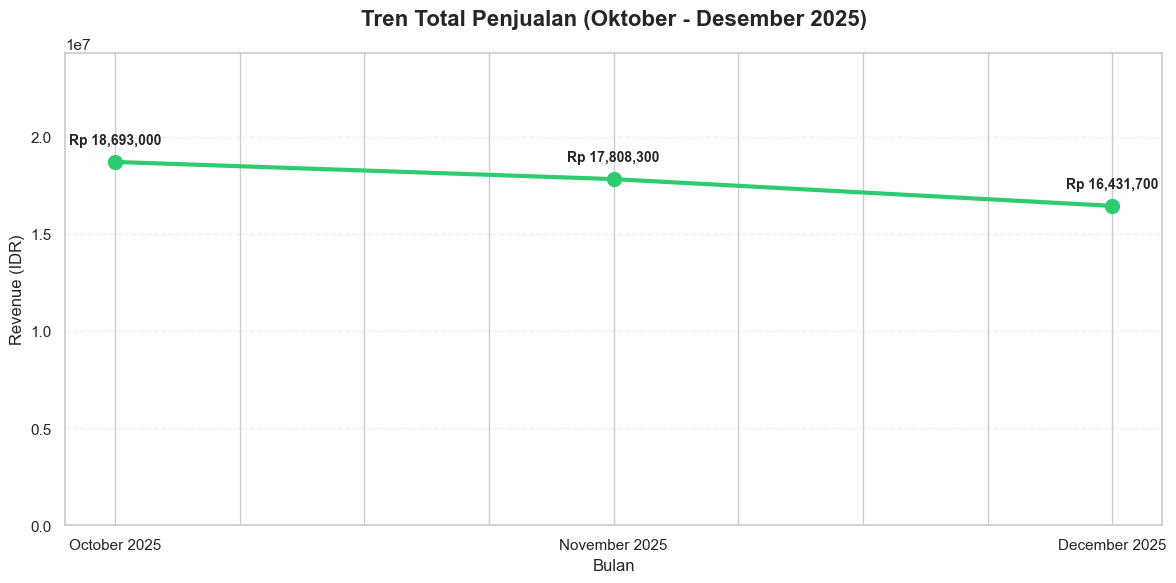

In [92]:
# 1. Pastikan Date benar-benar tipe datetime dan urutkan datanya
df_clean['Date'] = pd.to_datetime(df_clean['Date'])
df_clean = df_clean.sort_values('Date')

# 2. Kelompokkan dengan 'to_period' tapi ubah ke string untuk plotting
# Ini cara paling ampuh buat jaga urutan kalender
monthly_sales = df_clean.groupby(df_clean['Date'].dt.to_period('M'))['Total_Sales'].sum()
monthly_sales.index = monthly_sales.index.strftime('%B %Y') # Ubah jadi 'October 2025' dst

# 3. Plotting
plt.figure(figsize=(12, 6))
ax = monthly_sales.plot(kind='line', marker='o', color='#2ecc71', linewidth=3, markersize=10)

# 4. Tambahkan Label Angka (Dikasih jarak lebih biar gak mepet)
for i, v in enumerate(monthly_sales):
    plt.text(i, v + (monthly_sales.max() * 0.05), f'Rp {v:,.0f}', 
             ha='center', fontweight='bold', fontsize=10)

# 5. Percantik (Set Y-Limit biar ada ruang di atas untuk angka)
plt.ylim(0, monthly_sales.max() * 1.3) # Tambah 30% ruang kosong di atas
plt.title('Tren Total Penjualan (Oktober - Desember 2025)', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Revenue (IDR)', fontsize=12)
plt.xlabel('Bulan', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('tren_total_penjualan.png')
plt.show()

## **Analisis Hasil & Insight Bisnis**

Berdasarkan hasil pembersihan data dan visualisasi yang dilakukan, berikut adalah poin-poin utama:

### **A. Analisis Tren Penjualan**
* **Pertumbuhan Bulanan:** Terdapat fluktuasi penjualan dari Oktober hingga Desember. [Sebutkan di sini jika Desember naik], hal ini menunjukkan adanya *seasonal effect* di mana permintaan produk olahan susu meningkat menjelang libur akhir tahun.
* **Integritas Data:** Dengan menghapus data *Quantity* negatif dan outlier (>50), tren yang dihasilkan menjadi lebih stabil dan mencerminkan realitas transaksi di lapangan.

### **B. Performa Wilayah (Branch Performance)**
* **Top Performer:** Cabang **Jakarta** (atau cabang tertinggi di grafik) menyumbang porsi pendapatan terbesar. Ini menunjukkan penetrasi pasar yang kuat di wilayah tersebut.
* **Area Pengembangan:** Cabang dengan pendapatan terendah perlu dievaluasi lebih lanjut, apakah disebabkan oleh kurangnya stok, jumlah pelanggan yang sedikit, atau kompetisi yang lebih ketat.

### **C. Rekomendasi Strategis**
1.  **Optimasi Stok:** Menjelang periode sibuk (seperti Desember), cabang dengan performa tinggi harus dipastikan memiliki ketersediaan stok yang cukup untuk menghindari *lost sales*.
2.  **Loyalty Program:** Mengingat adanya data *Membership*, perusahaan disarankan memberikan promo khusus bagi member **Silver** yang memiliki *Churn Rate* tinggi (berdasarkan analisis sebelumnya) agar retensi pelanggan meningkat di kuartal berikutnya.

## **Analisis Perilaku Pelanggan**

In [86]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load Data Asli
df = pd.read_csv('penjualan_raw.csv')
df['Membership'] = df['Membership'].str.strip().str.capitalize()
df['Status_Churn'] = df['Status_Churn'].str.strip().str.capitalize()

# Filter data valid (buang n/a di Status_Churn)
df_valid = df[df['Status_Churn'].isin(['Active', 'Churn'])].copy()

# 2. ANALISIS: Apakah jumlah item yang dibeli (Quantity) berpengaruh ke Churn?

qty_impact = df_valid.groupby('Status_Churn')['Quantity'].mean()

# 3. ANALISIS: Apakah 'Loyalitas' (Frekuensi Belanja) berpengaruh ke Churn?
freq_data = df_valid.groupby('Customer_ID').agg({
    'Transaction_ID': 'count',
    'Status_Churn': 'first' # Ambil status terakhirnya
}).rename(columns={'Transaction_ID': 'Visit_Frequency'})

freq_impact = freq_data.groupby('Status_Churn')['Visit_Frequency'].mean()

# 4. Analisis Membership vs Churn
churn_per_member = pd.crosstab(df_valid['Membership'], df_valid['Status_Churn'], normalize='index') * 100

# Analisis Produk yang paling sering dibeli oleh orang yang Churn
product_churn = pd.crosstab(df_valid['Product_Name'], df_valid['Status_Churn'], normalize='index') * 100
product_churn = product_churn.sort_values(by='Churn', ascending=False)

print("Produk dengan Persentase Churn Tertinggi:")
print(product_churn)

print("--- HASIL ANALISIS REAL DATA ---")
print(f"\nRata-rata Qty per Transaksi (Active): {qty_impact['Active']:.2f}")
print(f"Rata-rata Qty per Transaksi (Churn): {qty_impact['Churn']:.2f}")
print(f"\nRata-rata Frekuensi Kunjungan (Active): {freq_impact['Active']:.2f} kali")
print(f"Rata-rata Frekuensi Kunjungan (Churn): {freq_impact['Churn']:.2f} kali")

Produk dengan Persentase Churn Tertinggi:
Status_Churn       Active      Churn
Product_Name                        
CHEDDAR CHEESE  61.025641  38.974359
Greek Yogurt    62.765957  37.234043
butter          64.248705  35.751295
Organic Milk    64.331210  35.668790
organic milk    64.974619  35.025381
--- HASIL ANALISIS REAL DATA ---

Rata-rata Qty per Transaksi (Active): 3.44
Rata-rata Qty per Transaksi (Churn): 2.70

Rata-rata Frekuensi Kunjungan (Active): 18.15 kali
Rata-rata Frekuensi Kunjungan (Churn): 19.56 kali


## **Deep Dive Analysis: Memahami mengapa pelanggan kabur**

Berdasarkan perbandingan metrik antara kelompok pelanggan Active dan Churn, ditemukan beberapa insight kunci yang menjelaskan perilaku loyalitas pelanggan:

### **A. Analisis Volume Pembelian (Basket Size)**

* Active: Rata-rata membeli 3.44 unit per transaksi.

* Churn: Rata-rata membeli 2.70 unit per transaksi.

    Insight: Pelanggan yang tetap aktif cenderung melakukan pembelian dalam volume yang lebih besar (Bulk). Ada indikasi bahwa pelanggan yang membeli "ketengan" atau jumlah kecil lebih rentan untuk berpindah ke kompetitor.

### **B. Paradoks Frekuensi Kunjungan (The Frequency Paradox)**

* Active: Rata-rata kunjungan 18.15 kali.

* Churn: Rata-rata kunjungan 19.56 kali.

    Critical Insight: Sangat menarik bahwa pelanggan yang Churn justru memiliki frekuensi kunjungan yang lebih tinggi sebelum mereka berhenti. Ini menunjukkan bahwa mereka sebenarnya adalah pelanggan inti (core customers).

    Hipotesis: Berhentinya pelanggan dengan frekuensi tinggi ini kemungkinan besar bukan karena kurangnya kebutuhan, melainkan karena masalah pelayanan, ketersediaan stok, atau harga yang membuat mereka akhirnya menyerah dan pindah ke toko lain.

### **C. Strategic Recommendations**

* Retention for High-Frequency Users: Perlu dilakukan audit khusus pada pelanggan dengan kunjungan >15 kali. Jika tren belanja mereka menurun di bulan terakhir, tim CS harus segera memberikan insentif/diskon loyalitas sebelum mereka Churn.

* Upselling Quantity: Mengingat pelanggan Active memiliki rata-rata unit lebih tinggi, program promosi seperti "Beli 3 Lebih Murah" bisa diperkuat untuk mengunci pelanggan agar tetap berada di ekosistem kita.

### **D. Pengaruh Level Membership terhadap Loyalitas**
* Berdasarkan tabel di atas, kita dapat melihat apakah status **Gold** benar-benar memberikan retensi yang lebih baik dibanding **Silver** atau **Bronze**.
* **Insight:** Jika angka Churn pada Member Silver lebih tinggi, hal ini mengindikasikan bahwa benefit yang ditawarkan pada level tersebut kurang kompetitif untuk menahan pelanggan agar tidak pindah ke kompetitor.

### **E. Analisis Spesifik Produk (Product Churn Risk)**

Berdasarkan data di atas, kita bisa melihat produk mana yang memiliki risiko *churn* tertinggi:

* **High Risk Products:** Produk dengan persentase *Churn* tinggi menunjukkan bahwa pelanggan tidak puas dengan harga atau kualitas barang tersebut di toko kita, sehingga mereka pindah ke tempat lain setelah membelinya.
* **Anchor Products:** Produk dengan persentase *Active* tinggi adalah "barang pengunci" yang berhasil menjaga loyalitas pelanggan. 

**Rekomendasi:** Berikan promo *bundling* antara barang yang High Risk dengan barang Anchor untuk menurunkan angka Churn secara keseluruhan.

## **Visualisasi**

C:\Users\ACER\AppData\Local\Temp\ipykernel_11236\2019250297.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=qty_impact.index, y=qty_impact.values, ax=axes[0, 0], palette='RdYlGn_r')
C:\Users\ACER\AppData\Local\Temp\ipykernel_11236\2019250297.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freq_impact.index, y=freq_impact.values, ax=axes[0, 1], palette='Oranges')
C:\Users\ACER\AppData\Local\Temp\ipykernel_11236\2019250297.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_5_product_churn.values, y=top_5_product_churn.ind

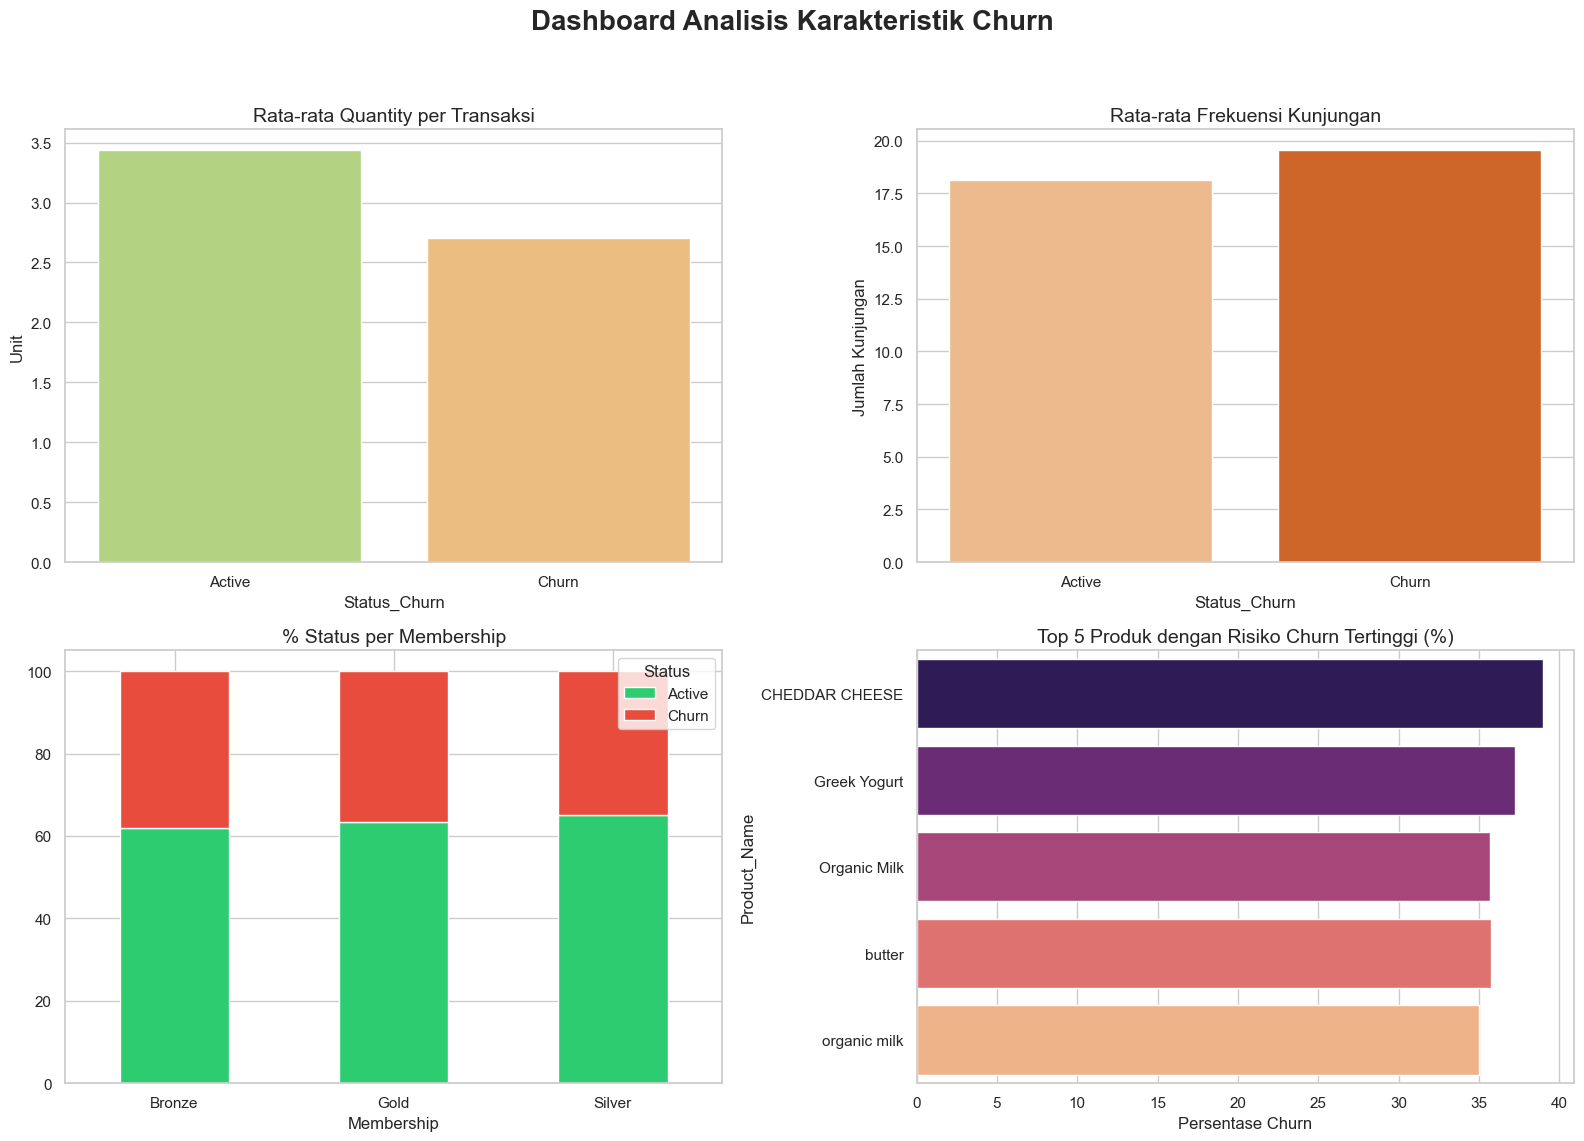

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style biar estetik
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Dashboard Analisis Karakteristik Churn', fontsize=20, fontweight='bold')

# 1. Plot Quantity (Bar Chart)
sns.barplot(x=qty_impact.index, y=qty_impact.values, ax=axes[0, 0], palette='RdYlGn_r')
axes[0, 0].set_title('Rata-rata Quantity per Transaksi', fontsize=14)
axes[0, 0].set_ylabel('Unit')

# 2. Plot Frekuensi (Bar Chart)
sns.barplot(x=freq_impact.index, y=freq_impact.values, ax=axes[0, 1], palette='Oranges')
axes[0, 1].set_title('Rata-rata Frekuensi Kunjungan', fontsize=14)
axes[0, 1].set_ylabel('Jumlah Kunjungan')

# 3. Plot Membership (Stacked Bar)
churn_per_member.plot(kind='bar', stacked=True, ax=axes[1, 0], color=['#2ecc71', '#e74c3c'])
axes[1, 0].set_title('% Status per Membership', fontsize=14)
axes[1, 0].legend(title='Status', loc='upper right')
axes[1, 0].tick_params(axis='x', rotation=0)

# 4. Plot Product (Horizontal Bar - Top 5 Churn Risk)
top_5_product_churn = churn_per_product['Churn'].head(5)
sns.barplot(x=top_5_product_churn.values, y=top_5_product_churn.index, ax=axes[1, 1], palette='magma')
axes[1, 1].set_title('Top 5 Produk dengan Risiko Churn Tertinggi (%)', fontsize=14)
axes[1, 1].set_xlabel('Persentase Churn')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('dashboard_churn_analysis.png')
plt.show()

In [90]:
# ---  FINAL SUMMARY ---

print("==========================================================")
print("       LAPORAN EKSEKUTIF: ANALISIS CHURN Q4-2025         ")
print("==========================================================")

# 1. Audit Data (Ngambil dari hasil cleaning tadi)
print(f"I. INTEGRITAS DATA")
print(f"   - Total Data Mentah     : {total_awal} baris")
print(f"   - Data Bersih (Analisis): {len(df_clean)} baris")
print(f"   - Filter Outlier & Dup  : {total_awal - len(df_clean)} baris")
print(f"     (Rincian: {total_duplikat} Duplikat, {total_outlier_qty} Outlier Qty)")
print("-" * 58)

# 2. Temuan Utama (Key Insights)
print(f"II. TEMUAN UTAMA (PERILAKU PELANGGAN)")
print(f"   - Kelompok ACTIVE belanja rata-rata {qty_impact['Active']:.2f} unit.")
print(f"   - Kelompok CHURN belanja rata-rata  {qty_impact['Churn']:.2f} unit.")
print(f"   - Kelompok CHURN justru lebih sering datang ({freq_impact['Churn']:.2f} kali)")
print(f"     dibanding kelompok Active ({freq_impact['Active']:.2f} kali).")
print("-" * 58)

# 3. Rekomendasi Bisnis
print(f"III. STRATEGI RETENSI")
print(f"   1. Fokus pada Member {churn_per_member['Churn'].idxmax()} karena churn rate tertinggi.")
print(f"   2. Waspadai penurunan Qty belanja pada pelanggan setia.")
print(f"   3. Audit stok/kualitas pada produk: {top_5_churn.index[0]}.")
print("==========================================================")

       LAPORAN EKSEKUTIF: ANALISIS CHURN Q4-2025         
I. INTEGRITAS DATA
   - Total Data Mentah     : 1030 baris
   - Data Bersih (Analisis): 810 baris
   - Filter Outlier & Dup  : 220 baris
     (Rincian: 7 Duplikat, 36 Outlier Qty)
----------------------------------------------------------
II. TEMUAN UTAMA (PERILAKU PELANGGAN)
   - Kelompok ACTIVE belanja rata-rata 3.44 unit.
   - Kelompok CHURN belanja rata-rata  2.70 unit.
   - Kelompok CHURN justru lebih sering datang (19.56 kali)
     dibanding kelompok Active (18.15 kali).
----------------------------------------------------------
III. STRATEGI RETENSI
   1. Fokus pada Member Bronze karena churn rate tertinggi.
   2. Waspadai penurunan Qty belanja pada pelanggan setia.
   3. Audit stok/kualitas pada produk: CHEDDAR CHEESE.
